In [ ]:
!pip install -U -q gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import pprint
import numpy as np
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
import gymnasium as gym
import collections
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [ ]:
# Alumas variáveis globais
ACTIONS = ["UP", "DOWN", "LEFT", "RIGHT"]
GRID_SHAPE = (4, 7)
UNICODE_ARROWS = {"UP": "\u2191", "DOWN": "\u2193", "LEFT": "\u2190", "RIGHT": "\u2192"}

In [ ]:
class Environment():
    def __init__(self):

        self.start_state = [3, 0]
        self.action_space = gym.spaces.Discrete(4)
        self.current_state = self.start_state
        self.timestep = 0
        self.reward_function = np.array( [
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0,-1.0,-1.0,-1.0,-1.0,-1.0, 1.0],
             ] )
        self.walkable_terrain = np.array( [
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],
             ] )
        self.terminal_states = [[3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6]]

    def _transition_function(self, current_state, action):

        if action == "UP":
            desired_state = [current_state[0]-1, current_state[1]]
        elif action == "DOWN":
            desired_state = [current_state[0]+1, current_state[1]]
        elif action == "LEFT":
            desired_state = [current_state[0], current_state[1]-1]
        elif action == "RIGHT":
            desired_state = [current_state[0], current_state[1]+1]
        else:
            raise Exception("Action | {} | outside the action space".format(action))

        # Check if the desired state is inside the grid
        if ( desired_state[0] < self.walkable_terrain.shape[0] and
            desired_state[1] < self.walkable_terrain.shape[1] and
            desired_state[0] >= 0 and
            desired_state[1] >= 0  ):

            # Should the desired state be inside the grid, check if it's walkable
            if self.walkable_terrain[desired_state[0]][desired_state[1]]:
                current_state = desired_state

        # If neither condition is met then the state remains unchanged i.e. he bumped into a wall
        return current_state


    def step(self, action):
        action = ACTIONS[action]
        self.current_state = self._transition_function(self.current_state, action)
        obs = self.current_state
        reward = self.reward_function[self.current_state[0]][self.current_state[1]]
        done = (self.current_state in self.terminal_states)
        info = {}
        self.timestep += 1
        trunc = self.timestep >= 30

        return obs, reward, done, trunc, info

    def reset(self, custom_start=None):
        # !!! O custom_start não é usual e está presente aqui somente para realizar a
        # avaliação de políticas exatamente como descrita na teoria

        if custom_start:
            self.current_state = custom_start
        else:
            self.current_state = self.start_state
        self.timestep = 0
        obs = self.current_state
        info = {}

        return obs, info

    def render(self):
        fig, ax = plt.subplots()
        ax.matshow(self.reward_function, cmap="winter")
        ax.text(self.current_state[1], self.current_state[0], '\u22A0', ha='center', va='center', fontsize="xx-large")
        plt.show()

## Q-Learning

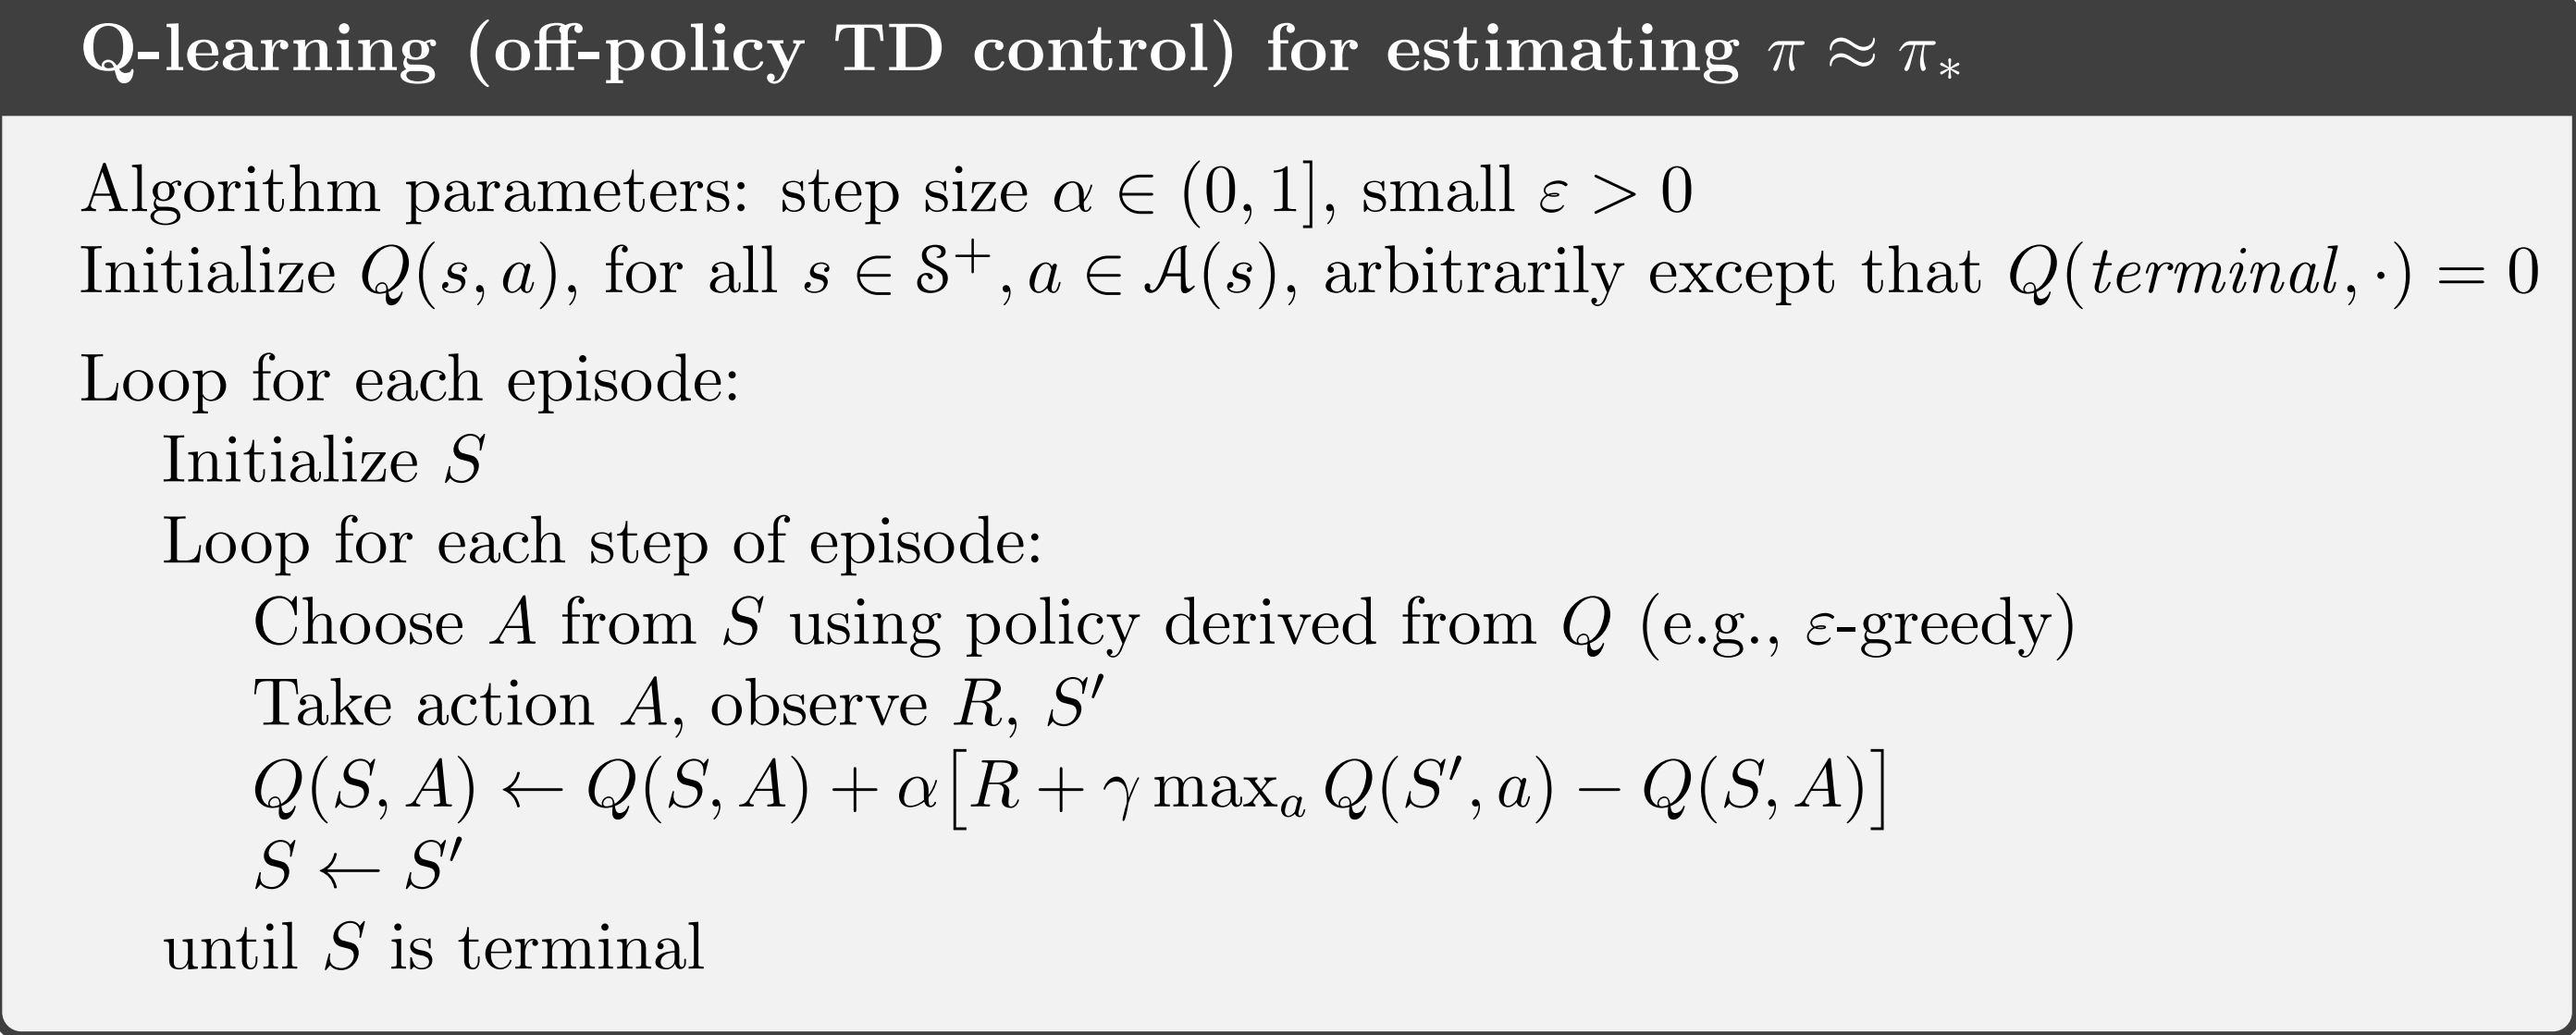

O agente a seguir possui uma função para a escolha da melhor ação dada uma função Q. Complete-o com os métodos faltantes para a política e-greedy e para o aprendizado (atualização) da função Q de acordo com o algoritmo do Q-Learning.

In [ ]:
class Q_Agent():
    def __init__(self, epsilon, alpha, action_space):
        # função Q inicializada com dicionário onde as chaves são tuplas (estado, ação)
        self.Q = collections.defaultdict(float)
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_space = action_space

    # Dado um estado, esta função retorna a melhor ação e o seu valor
    # Caso duas ações possuam o mesmo valor, uma aleatória (entre essas) é escolhida
    def best_value_and_action(self, state):
        a_values = []
        for action in range(self.action_space.n):
            a_values.append(self.Q[(str(state), action)])
        best_value = max(a_values)
        indices = [idx for idx, val in enumerate(a_values) if val == best_value] # separa indices com maior valor
        best_action = np.random.choice(indices) # escolhe aleatoriamente entre os índices de melhor valor
        return best_value, best_action

    # Função para política epsilon-greedy, retorna a ação escolhida
    def e_greedy(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.action_space.sample()
        else:
            _, action = self.best_value_and_action(state)
        return action

    # Função de aprendizado usando o algoritmo Q-Learning
    def learn(self, state, action, reward, next_state):
        best_next_value, _ = self.best_value_and_action(next_state)
        current_q = self.Q[(str(state), action)]

        # Atualização Q-Learning
        new_q = current_q + self.alpha * (reward + GAMMA * best_next_value - current_q)
        self.Q[(str(state), action)] = new_q



## SARSA

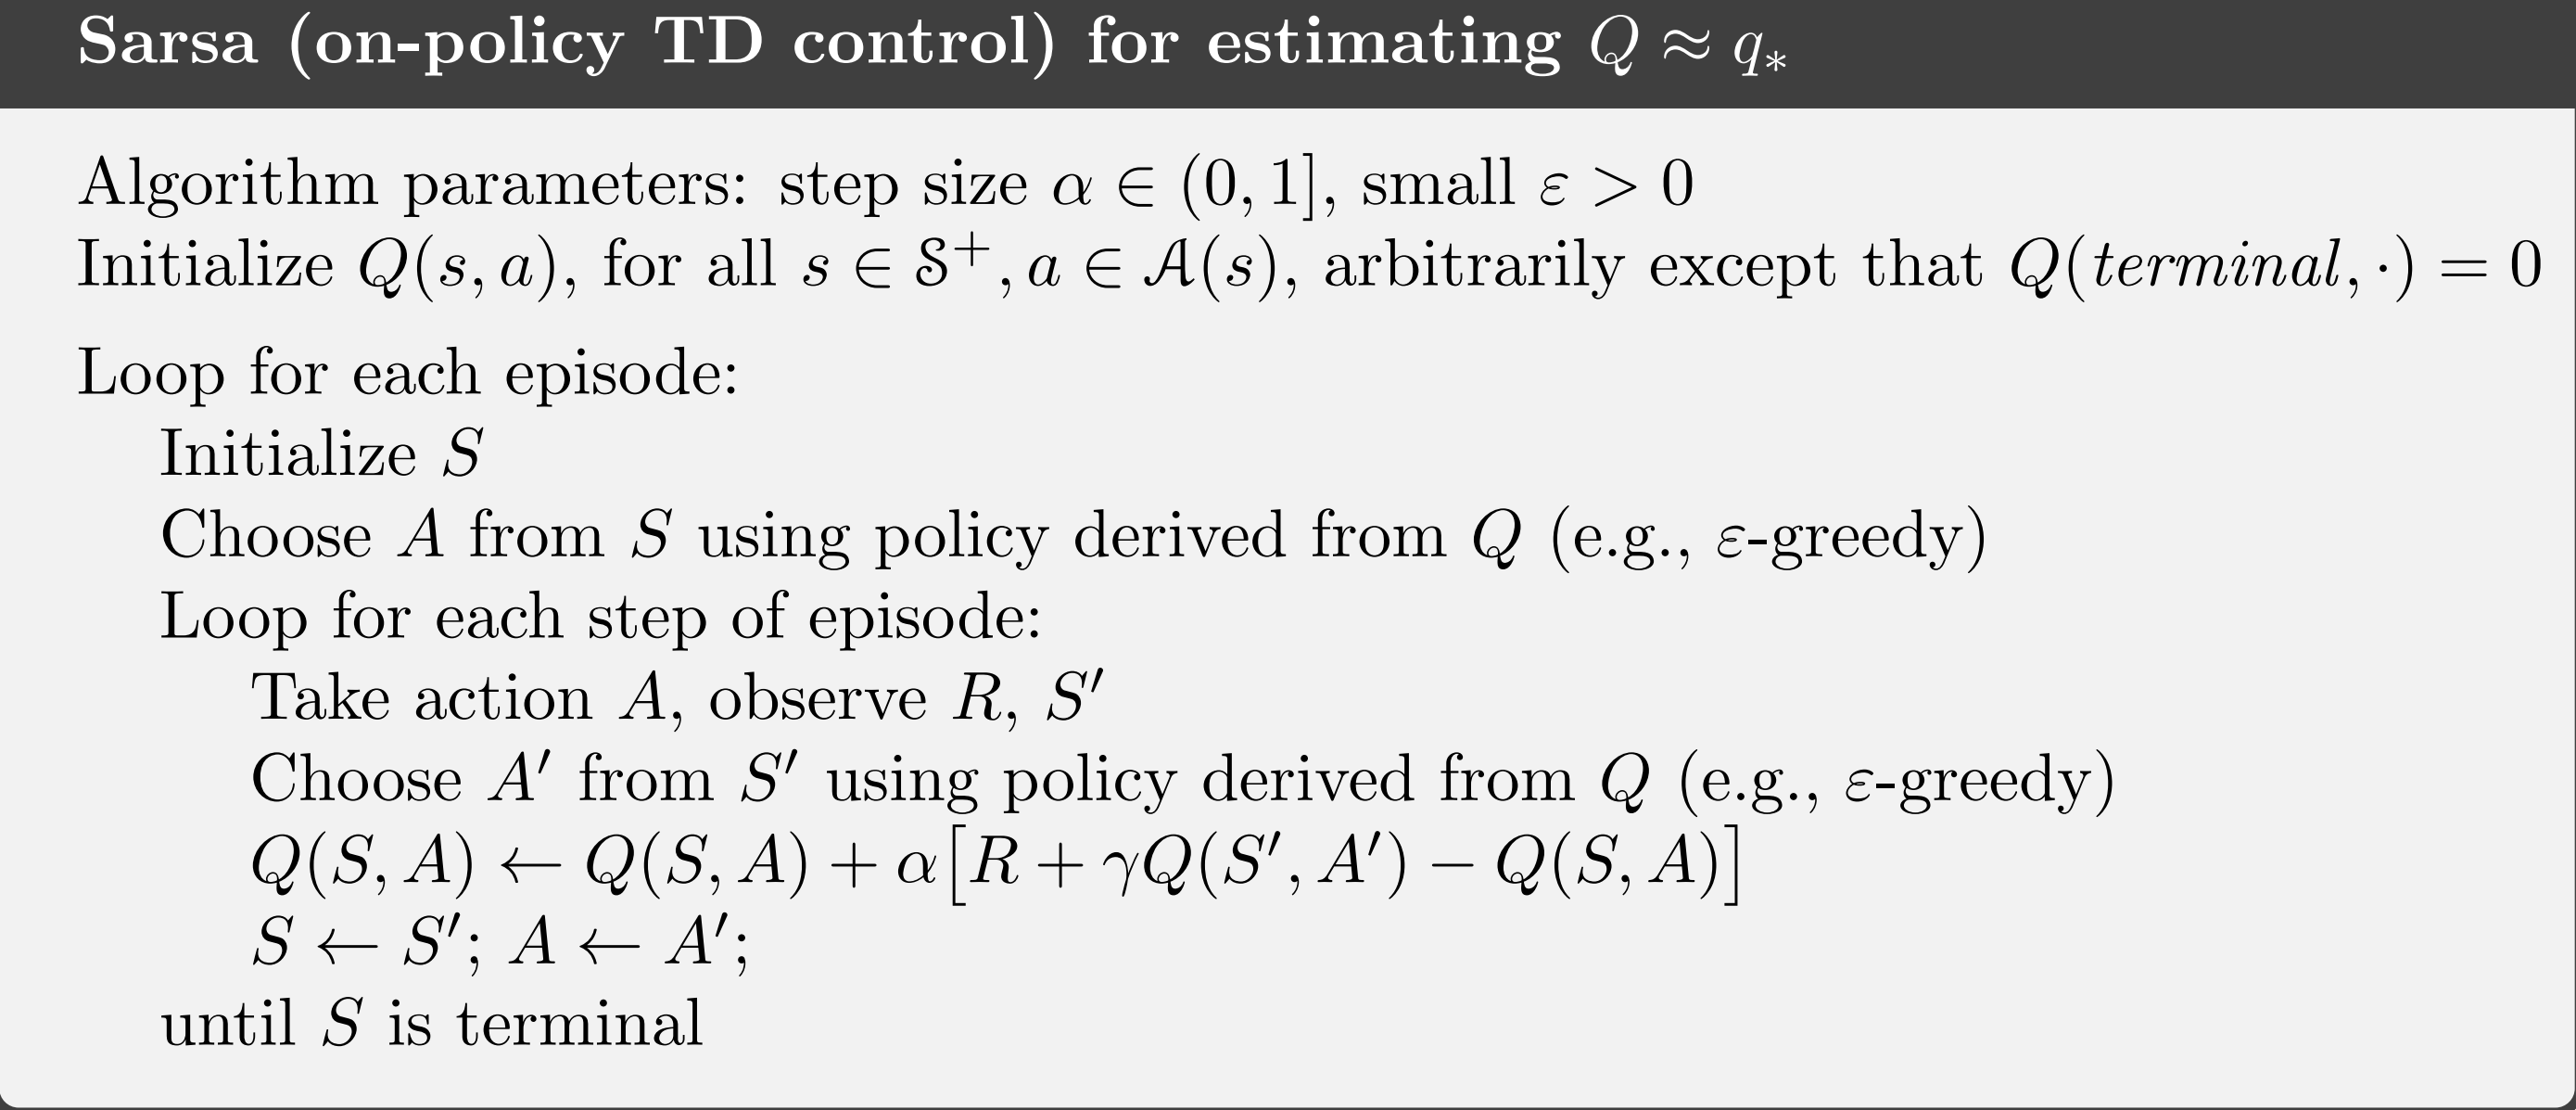

O agente a seguir possui uma função para a escolha da melhor ação dada uma função Q. Complete-o com os métodos faltantes para a política e-greedy e para o aprendizado(atualização) da função Q de acordo com o algoritmo do SARSA.

In [ ]:
class SARSA_Agent():
    def __init__(self, epsilon, alpha, action_space):
        # função Q inicializada com dicionário onde as chaves são tuplas (estado, ação)
        self.Q = collections.defaultdict(float)
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_space = action_space

    # Dado um estado, esta função retorna a melhor ação e o seu valor
    # Caso duas ações possuam o mesmo valor, uma aleatória (entre essas) é escolhida
    def best_value_and_action(self, state):
        a_values = []
        for action in range(self.action_space.n):
            a_values.append(self.Q[(str(state), action)])
        best_value = max(a_values)
        indices = [idx for idx, val in enumerate(a_values) if val == best_value] # separa indices com maior valor
        best_action = np.random.choice(indices) # escolhe aleatoriamente entre os índices de melhor valor
        return best_value, best_action

    # Função para política epsilon-greedy, retorna a ação escolhida
    def e_greedy(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.action_space.sample()  # ação aleatória
        else:
            _, action = self.best_value_and_action(state)
        return action

    # Função de aprendizado usando o algoritmo SARSA
    def learn(self, state, action, reward, next_state):
        next_action = self.e_greedy(next_state)
        current_q = self.Q[(str(state), action)]
        next_q = self.Q[(str(next_state), next_action)]

        # Atualização SARSA
        new_q = current_q + self.alpha * (reward + GAMMA * next_q - current_q)
        self.Q[(str(state), action)] = new_q



## Loop de treinamento

In [ ]:
def run_learning(agent_class, epsilon, alpha, max_iterations, test_episodes):
    env = Environment()
    test_env = Environment()

    agent = agent_class(epsilon, alpha, env.action_space)

    metrics = collections.defaultdict(list)

    iter_no = 0
    best_reward = -1000.0
    state, _ = env.reset()
    while iter_no < max_iterations:
        iter_no += 1
        action = agent.e_greedy(state)
        next_s, r, is_term, is_trunc, _ = env.step(action)

        agent.learn(state, action, r, next_s)

        is_done = is_term or is_trunc
        if is_done:
            state, _ = env.reset()
        else:
            state = next_s

        sum_reward = 0.0
        sum_steps = 0.0
        for _ in range(test_episodes):

            # Para teste, executaremos vários episódios escolhendo apenas a ação de melhor valor de acordo com Q
            total_reward = 0.0
            _state, _ = test_env.reset()
            n_steps = 0
            while True:
                _, _action = agent.best_value_and_action(_state)
                _new_state, _r, _is_term, _is_trunc, _ = test_env.step(_action)
                _is_done = _is_term or _is_trunc
                total_reward += _r # somando a recompensa total do episódio
                n_steps+=1 # contando o tamanho do episódio
                if _is_done:
                    break
                _state = _new_state

            sum_reward += total_reward
            sum_steps += n_steps

        mean_reward = sum_reward/test_episodes
        mean_steps = sum_steps/test_episodes

        metrics["test_reward"].append(mean_reward)
        metrics["episode_len"].append(mean_steps)

        if mean_reward > best_reward:
            print("Best mean reward updated %.3f -> %.3f" % (
                best_reward, mean_reward))
            best_reward = mean_reward

    return agent, metrics

In [ ]:
def print_episode(agent):
    test_env = Environment()

    # Esta sessão apenas executa um único episodio para demonstração
    total_reward = 0.0
    _state, _ = test_env.reset()
    test_env.render()
    n_steps = 0
    while True:
        _, _action = agent.best_value_and_action(_state)
        _new_state, _r, _is_term, _is_trunc, _ = test_env.step(_action)
        test_env.render()
        _is_done = _is_term or _is_trunc
        total_reward += _r # somando a recompensa total do episódio
        n_steps+=1 # contando o tamanho do episódio
        if _is_done:
            break
        _state = _new_state

## Treinamento e análise

* Execute os códigos de treinamento a seguir e as células seguintes que explicitarão os gráficos decorrentes do aprendizado. Analise o comportamento do agente. Leia atentamente os gráficos e tire suas conclusões sobre os formatos das curvas. Há espaço para escrita após os gráficos.

Best mean reward updated -1000.000 -> -0.800
Best mean reward updated -0.800 -> -0.400
Best mean reward updated -0.400 -> -0.200
Best mean reward updated -0.200 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000


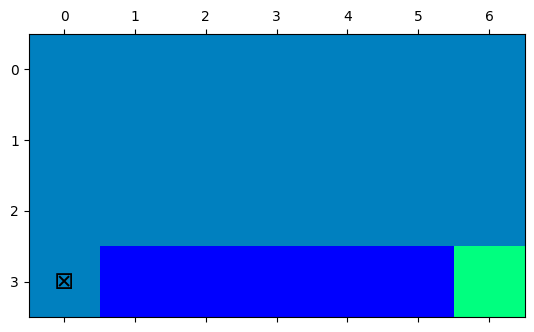

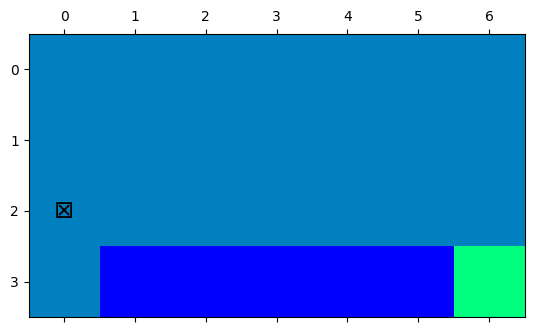

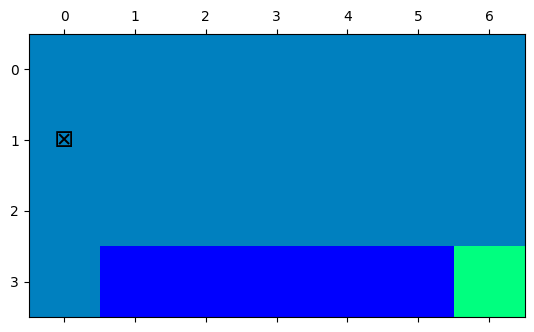

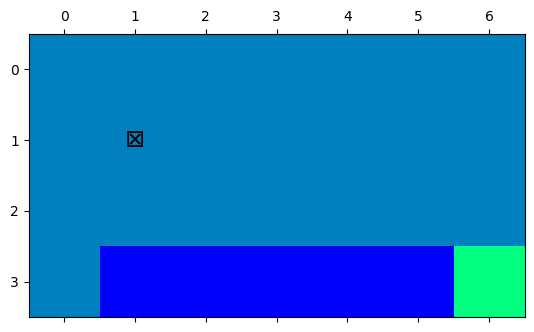

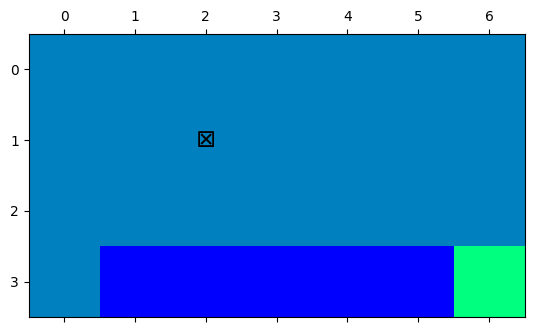

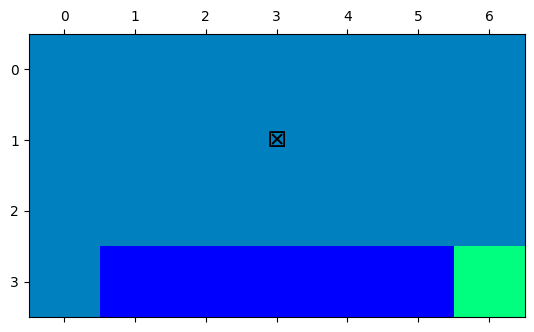

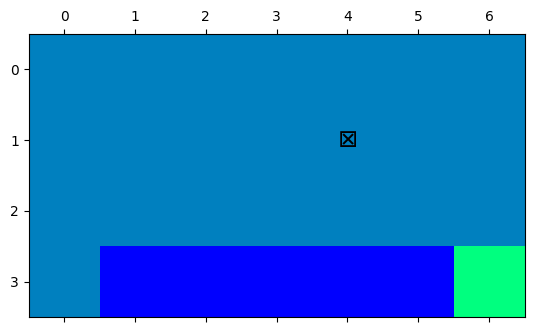

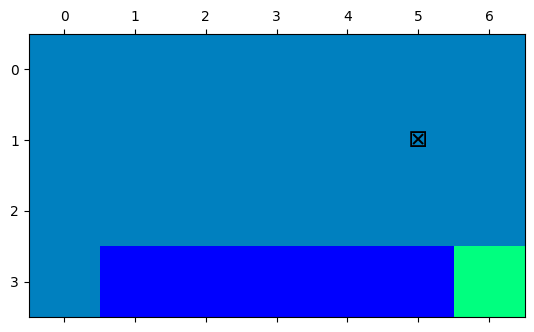

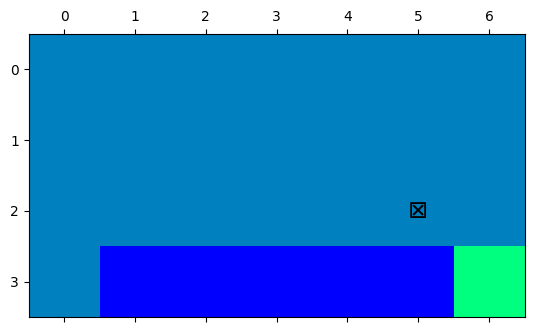

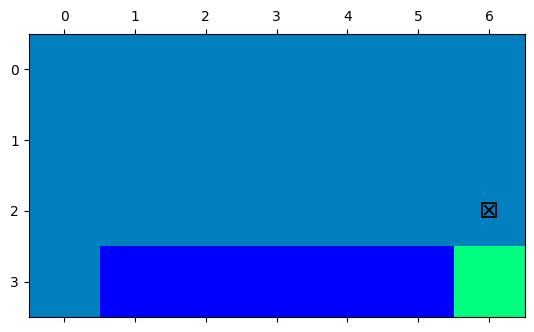

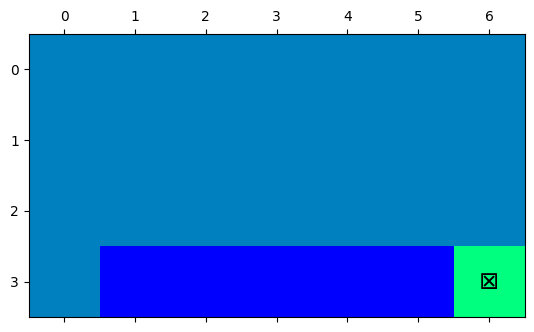

In [ ]:
# Treinamento com o SARSA
GAMMA = 0.9
agent, metrics = run_learning(SARSA_Agent, epsilon=0.1, alpha=0.5, max_iterations=5000, test_episodes=5)
print_episode(agent)

In [ ]:
px.line(metrics["episode_len"])

In [ ]:
px.line(metrics["test_reward"])

* Execute agora o treinamento utilizando o algoritmo Q-learning.

Best mean reward updated -1000.000 -> -1.000
Best mean reward updated -1.000 -> -0.800
Best mean reward updated -0.800 -> -0.600
Best mean reward updated -0.600 -> -0.200
Best mean reward updated -0.200 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000


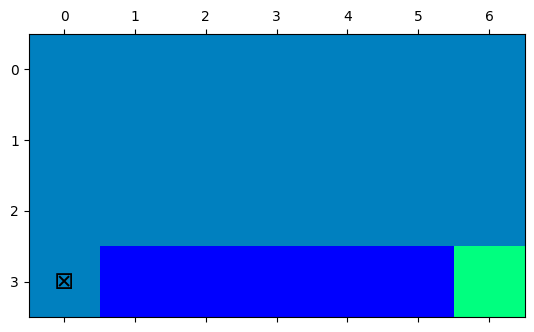

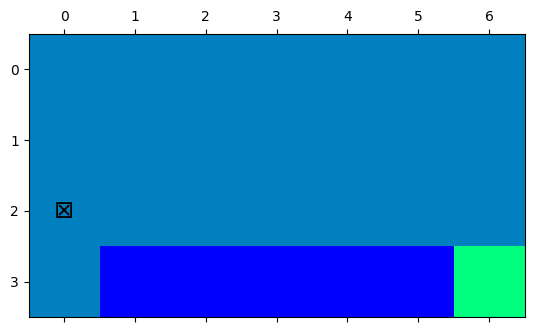

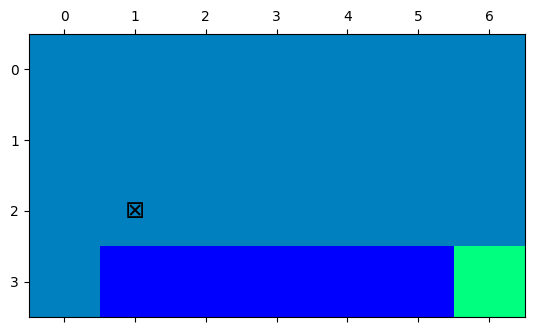

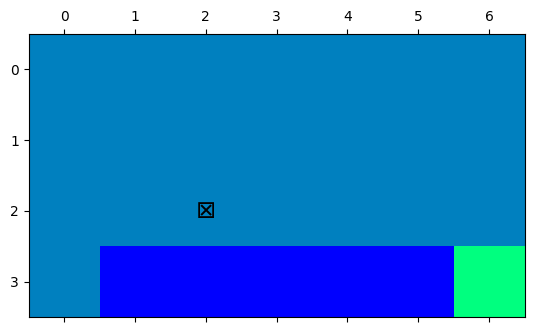

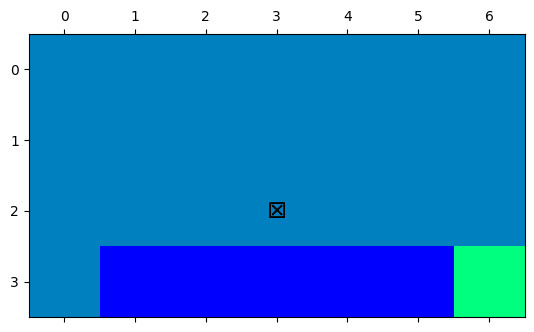

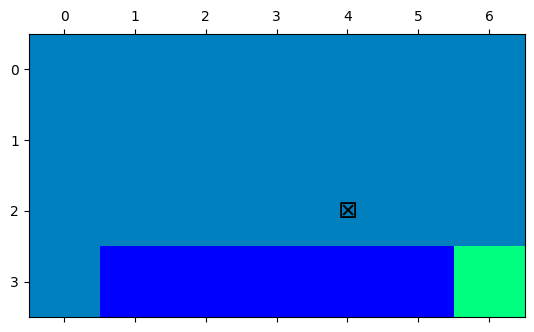

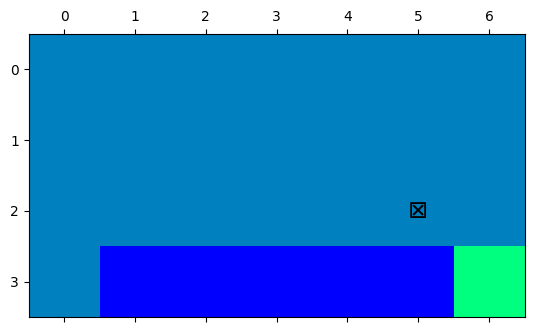

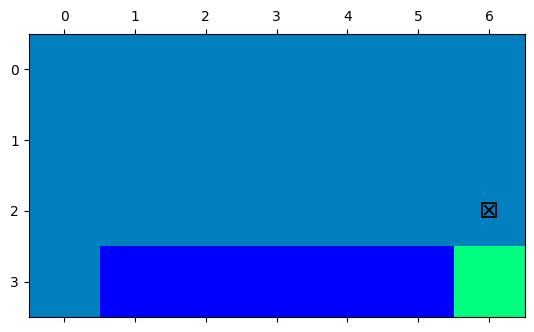

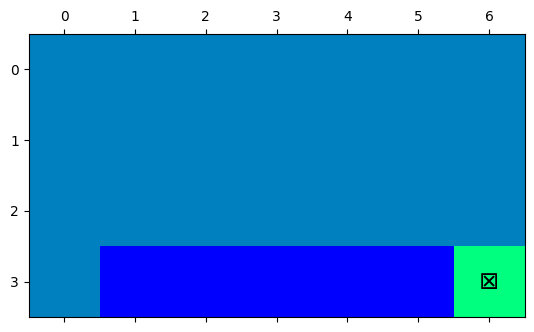

In [ ]:
# Treinamento com o Q-learning
GAMMA = 0.9
agent, metrics = run_learning(Q_Agent, epsilon=0.1, alpha=0.5, max_iterations=5000, test_episodes=5)
print_episode(agent)

In [ ]:
px.line(metrics["episode_len"])

In [ ]:
px.line(metrics["test_reward"])

* Analise o comportamento dos agentes treinados com os dois algoritmos. Explique as diferenças entre os agentes. O agente utilizou o melhor caminho possível?

>>

**SARSA (On-Policy):**

* Caminho seguro e cauteloso: O SARSA considera a próxima ação que o agente vai
tomar (via política epsilon-greedy). Isso resulta em decisões mais seguras e conservadoras, especialmente se houver estados com penalidades. O agente pode evitar estados arriscados, mesmo que isso leve a um caminho mais longo.
* Ação real no próximo estado: Atualiza os valores Q com base na ação que o agente efetivamente toma no próximo estado. Isso significa que o agente pode ser mais conservador e não tomar o caminho mais curto se ele parecer arriscado.
* Comportamento subótimo: Como SARSA prioriza a segurança, o agente pode escolher rotas menos eficientes, mas que minimizam penalidades ou riscos.

**Q-Learning (Off-Policy):**

* Caminho otimizado, mas arriscado: O Q-Learning atualiza os valores Q com base no valor máximo possível no próximo estado, sem considerar qual ação o agente realmente tomará. Isso faz com que o agente busque o caminho mais curto e recompensador, mesmo que envolva riscos.
* Foco em recompensas máximas: O Q-Learning sempre tenta maximizar a recompensa, podendo levar o agente a arriscar passar por estados com penalidades se isso der a maior recompensa a longo prazo.
* Comportamento mais eficiente, mas com risco: Tem maior probabilidade de encontrar o caminho mais curto, porém pode cair em estados com penalidades se a recompensa futura for alta.

**O agente utilizou o melhor caminho possível?**

Ambos agentes tomaram caminhos que visualmente, pelos gráficos, não foram os menores possíveis. SARSA se distanciou mais, por ser mais cuidadoso, já o Q-Learning menos.

* Explique aqui em um parágrafo o comportamento das curvas para cada agente. Houve quedas ou crescimentos acentuados? Por que? A curva de tamanho do episódio converge no mesmo formato que a de recompensa? Por que?

>>
Nos gráficos `test_reward` e `episode_len` do *`SARSA`*, percebe-se uma evolução em menos passos se comparado ao QLearning (aprox. 1000), mas depois os resultados ficam bastante instáveis.

>>
Já no *`QLearning`* a evolução ecorre em mais passos (aprox. 1500), e os valores ficam estáveis após isso.

* Varie os valores dos parâmetros `epsilon` e `alpha` e descreva os efeitos de cada combinação nas curvas de aprendizado de cada agente. O algoritmo é capaz de convergir em todos? Explique.

Efeitos de `epsilon` e `alpha` nas curvas de aprendizado:

1. `epsilon`:
   - **Alto**: Mais exploração, retarda convergência.
   - **Baixo**: Mais exploração da política atual, convergência mais rápida, mas arrisca subótimos.

2. `alpha`:
   - **Alto**: Atualizações rápidas, mas instáveis.
   - **Baixo**: Atualizações lentas, converge devagar.

**Combinações:**
- Alto epsilon, alto alpha: Explora muito, converge instável.
- Alto epsilon, baixo alpha: Explora bastante, mas converge lento.
- Baixo epsilon, alto alpha: Convergência rápida, risco de subótimo.
- Baixo epsilon, baixo alpha: Aprendizado muito lento.

**Convergência:**
- `SARSA`: Mais estável, converge em mais casos.
- `Q-Learning`: Pode não convergir com \(\epsilon\) e \(\alpha\) altos.



`TESTES`

Se abaixo o alpha (0.2) e o epsilon (0.1) no SARSA, ele fica mais estável após evolução;
Se aumento o alpha (0.9) e o Epsilon (0.8), ele converge em menos passos;
Com o alpha baixo.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

epsilon_values = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
plots = []

# tamanho do grid
num_rows = len(epsilon_values)
num_cols = len(alpha_values)

# figura de subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[f"ε={epsilon}, α={alpha}" for epsilon, alpha in itertools.product(epsilon_values, alpha_values)])

# diferentes combinações de epsilon e alpha
row = 1
col = 1
for epsilon, alpha in itertools.product(epsilon_values, alpha_values):
    # treinamento com o SARSA
    agent, metrics = run_learning(SARSA_Agent, epsilon=epsilon, alpha=alpha, max_iterations=5000, test_episodes=5)
    # gráfico de linha
    fig_line = px.line(metrics["episode_len"])
    # add o gráfico na célula correspondente do grid
    for trace in fig_line['data']:
        fig.add_trace(trace, row=row, col=col)

    # next to próxima coluna e linha
    col += 1
    if col > num_cols:
        col = 1
        row += 1

Best mean reward updated -1000.000 -> -0.600
Best mean reward updated -0.600 -> -0.400
Best mean reward updated -0.400 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000
Best mean reward updated -1000.000 -> -0.800
Best mean reward updated -0.800 -> -0.600
Best mean reward updated -0.600 -> -0.400
Best mean reward updated -0.400 -> -0.200
Best mean reward updated -0.200 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000
Best mean reward updated -1000.000 -> -0.800
Best mean reward updated -0.800 -> -0.400
Best mean reward updated -0.400 -> -0.200
Best mean reward updated -0.200 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean 

In [ ]:
# layout de grid
fig.update_layout(height=900, width=1300, title_text="Treinamentos SARSA com diferentes ε e α", showlegend=False)
fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

epsilon_values = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
plots = []

# tamanho do grid
num_rows = len(epsilon_values)
num_cols = len(alpha_values)

# figura de subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[f"ε={epsilon}, α={alpha}" for epsilon, alpha in itertools.product(epsilon_values, alpha_values)])

# diferentes combinações de epsilon e alpha
row = 1
col = 1
for epsilon, alpha in itertools.product(epsilon_values, alpha_values):
    # treinamento com o Q LEARNING
    agent, metrics = run_learning(Q_Agent, epsilon=epsilon, alpha=alpha, max_iterations=5000, test_episodes=5)
    # gráfico de linha
    fig_line = px.line(metrics["episode_len"])
    # add o gráfico na célula correspondente do grid
    for trace in fig_line['data']:
        fig.add_trace(trace, row=row, col=col)

    # next to próxima coluna e linha
    col += 1
    if col > num_cols:
        col = 1
        row += 1

Best mean reward updated -1000.000 -> -1.000
Best mean reward updated -1.000 -> -0.800
Best mean reward updated -0.800 -> 0.000
Best mean reward updated 0.000 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000
Best mean reward updated -1000.000 -> -1.000
Best mean reward updated -1.000 -> -0.800
Best mean reward updated -0.800 -> -0.600
Best mean reward updated -0.600 -> -0.400
Best mean reward updated -0.400 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mean reward updated 0.400 -> 0.600
Best mean reward updated 0.600 -> 0.800
Best mean reward updated 0.800 -> 1.000
Best mean reward updated -1000.000 -> -1.000
Best mean reward updated -1.000 -> -0.800
Best mean reward updated -0.800 -> -0.600
Best mean reward updated -0.600 -> -0.200
Best mean reward updated -0.200 -> 0.000
Best mean reward updated 0.000 -> 0.200
Best mean reward updated 0.200 -> 0.400
Best mea

In [ ]:
# layout de grid
fig.update_layout(height=900, width=1300, title_text="Treinamentos Q LEARNING com diferentes ε e α", showlegend=False)
fig.show()